# Highlight on the Canopy Height Model and Hillshade

## Setting up

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import seaborn as sns

import geopy as gp
import folium

from shapely.geometry import Point

import rasterio as rio
from rasterio.plot import show
from rasterio.windows import Window

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

In [2]:
from functions import *

In [3]:
# OpenStreet Map (gratuit, moins efficace)

country_code = -1

while country_code != 'be':
    address = input("Please, enter an address in Begium:\n")

    locator = gp.Nominatim(user_agent="myGeocoder")
    location = locator.geocode(address, addressdetails=True)
    
    postcode = int(location.raw['address']['postcode'])
    country_code = location.raw['address']['country_code']
    coord = (location.latitude, location.longitude)

print("Latitude = {}, Longitude = {}, Postcode = {}".format(coord[0], coord[1], postcode))

path_dsm = ""
path_dtm = ""
flanders = False

if postcode >= 1300 and postcode < 1500:
    path_dsm = set_path_dsm('BRABANT_WALLON')
    path_dtm = set_path_dtm('BRABANT_WALLON')
    print('Walloon Brabant')
    
elif postcode >= 4000 and postcode < 5000:
    path_dsm = set_path_dsm('LIEGE')
    path_dtm = set_path_dtm('LIEGE')
    print('Liège')
    
elif postcode >= 5000 and postcode < 6000:
    path_dsm = set_path_dsm('NAMUR')
    path_dtm = set_path_dtm('NAMUR')
    print('Namur')
    
elif (postcode >= 6000 and postcode < 6600) or (postcode >= 7000 and postcode < 8000):
    path_dsm = set_path_dsm('HAINAUT')
    path_dtm = set_path_dtm('HAINAUT')
    print('Hainaut')
    
elif postcode >= 6600 and postcode < 7000:
    path_dsm = set_path_dsm('LUXEMBOURG')
    path_dtm = set_path_dtm('LUXEMBOURG')
    print('Luxembourg')
    
else:
    number = [x for x in range(1, 44)]
    for i in number :
        pass
    flanders = True
    print('Brussels or Flanders region')
    
# Walloon region uses EPSG:31370
# Flanders region uses EPSG:?

if flanders == False:
    p = gpd.GeoSeries([Point(coord[1], coord[0])])
    p.crs = 'epsg:4326'
    p = p.to_crs(epsg=31370)
    print(p[0])
else:
    pass

coordinates = (
    (p[0].x, p[0].y),
)

# Window's size
N = 700

with rio.open(path_dsm) as dsm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dsm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dsm = dsm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dsm_meta = dsm.profile
        
with rio.open(path_dtm) as dtm:
    for i, (lon, lat) in enumerate(coordinates):
        # Get pixel coordinates from map coordinates
        py, px = dtm.index(lon, lat)
        print('Pixel Y, X coords: {}, {}'.format(py, px))
        
        # Build an NxN window
        small_dtm = dtm.read(1, window=Window(px - N//2, py - N//2, N, N), masked=True)
        dtm_meta = dtm.profile

Please, enter an address in Begium:
Gare de Namur
Latitude = 50.469100100000006, Longitude = 4.862421313946799, Postcode = 5000
Namur


C:\Users\morga\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


POINT (185046.4410823517 128813.7578461301)
Pixel Y, X coords: 21186, 41046
Pixel Y, X coords: 21186, 41046


## Canopy Height Model

DSM - DTM = CHM

In [4]:
lidar_chm = small_dsm - small_dtm

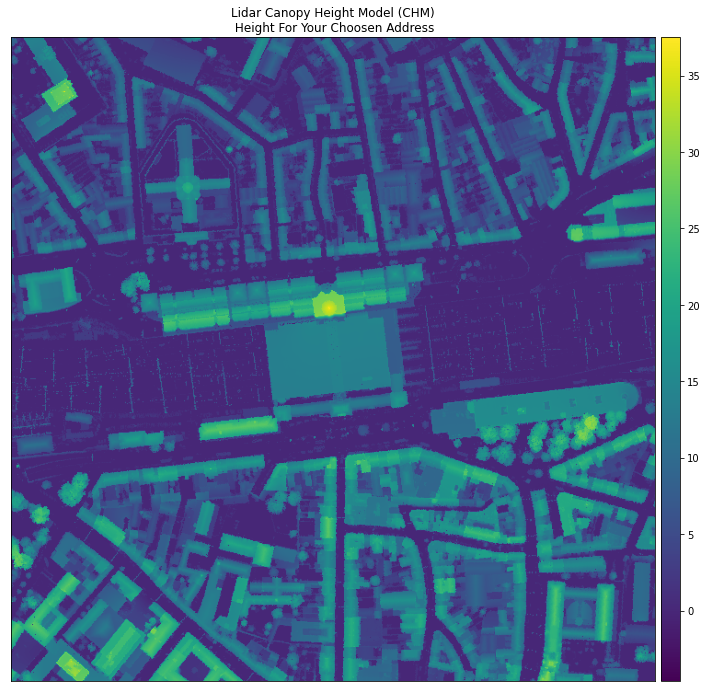

In [5]:
ep.plot_bands(lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

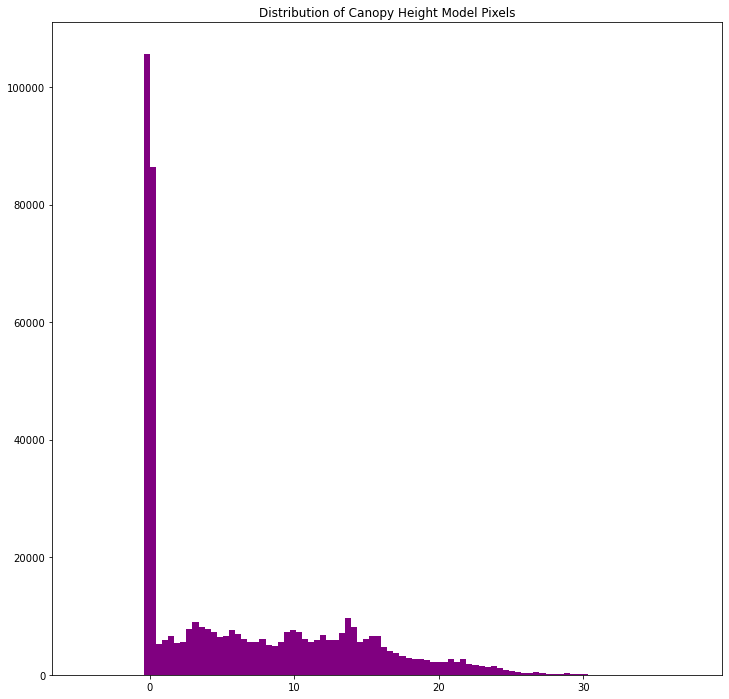

In [6]:
# view histogram of the data
ep.hist(lidar_chm,
        bins=100,
        title="Distribution of Canopy Height Model Pixels")
plt.show()

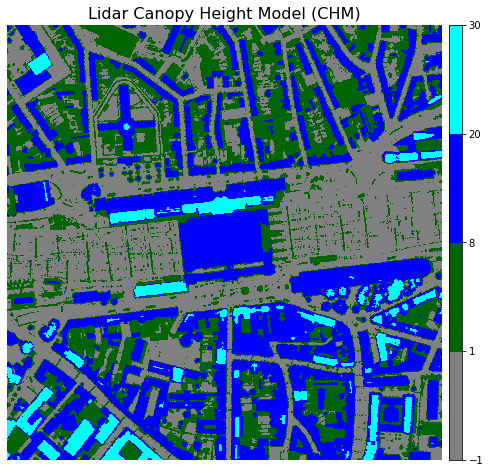

In [7]:
# Show the CHM with others colors

# Define the colors
cmap = ListedColormap(["grey", "darkgreen", "blue", "cyan"])

# Define a normalization from values -> colors
norm = colors.BoundaryNorm([-1, 1, 8, 20, 30], 5)

fig, ax = plt.subplots(figsize=(12, 8))
chm_plot = ax.imshow(lidar_chm, 
                     cmap=cmap, 
                     norm=norm)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)
ep.colorbar(chm_plot)
ax.set_axis_off()
plt.show()

## Cleaning

In [8]:
# CLEANUP: Set CHM values of 0 or less to NAN
clean_lidar_chm = small_dsm - small_dtm
clean_lidar_chm[clean_lidar_chm <= 0] = np.nan

# View summary statistics of canopy height model after cleaning up the data
print('Mean:', np.nanmean(lidar_chm))
print('Max:', np.nanmax(lidar_chm))
print('Min:', np.nanmin(lidar_chm))

Mean: 6.3350453
Max: 37.489265
Min: -4.6289215


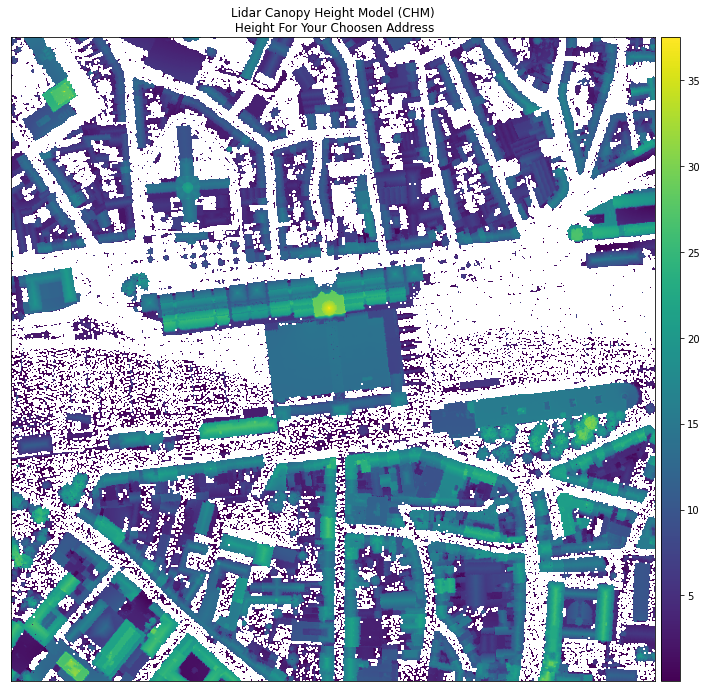

In [9]:
ep.plot_bands(clean_lidar_chm,
              cmap='viridis',
              title="Lidar Canopy Height Model (CHM)\n Height For Your Choosen Address")
plt.show()

## Getting a Hillshade

Text(0.5, 1.0, 'Lidar Canopy Height Model (CHM)')

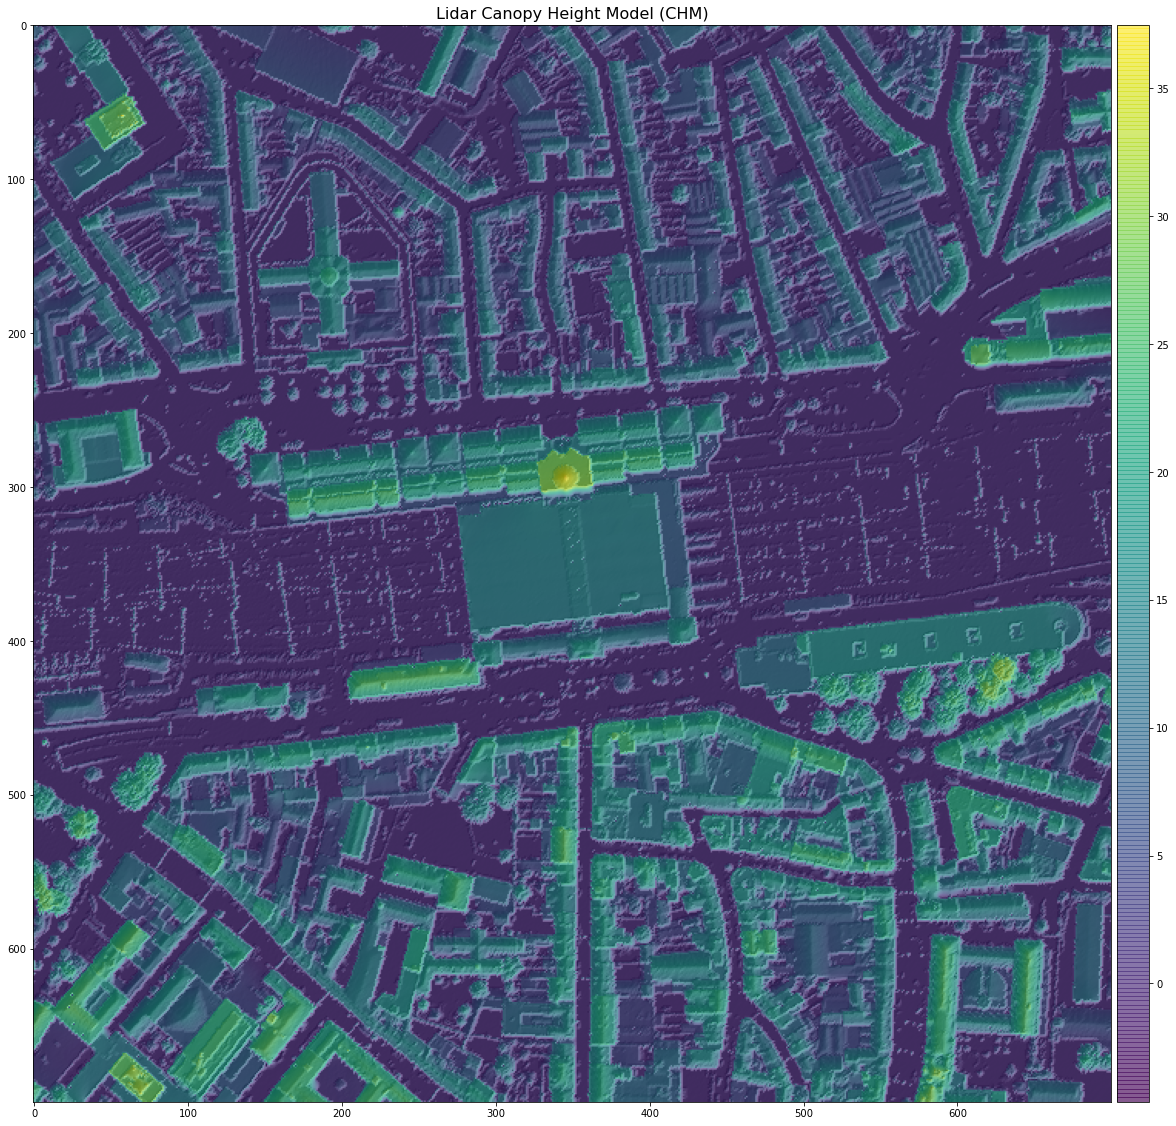

In [10]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16)

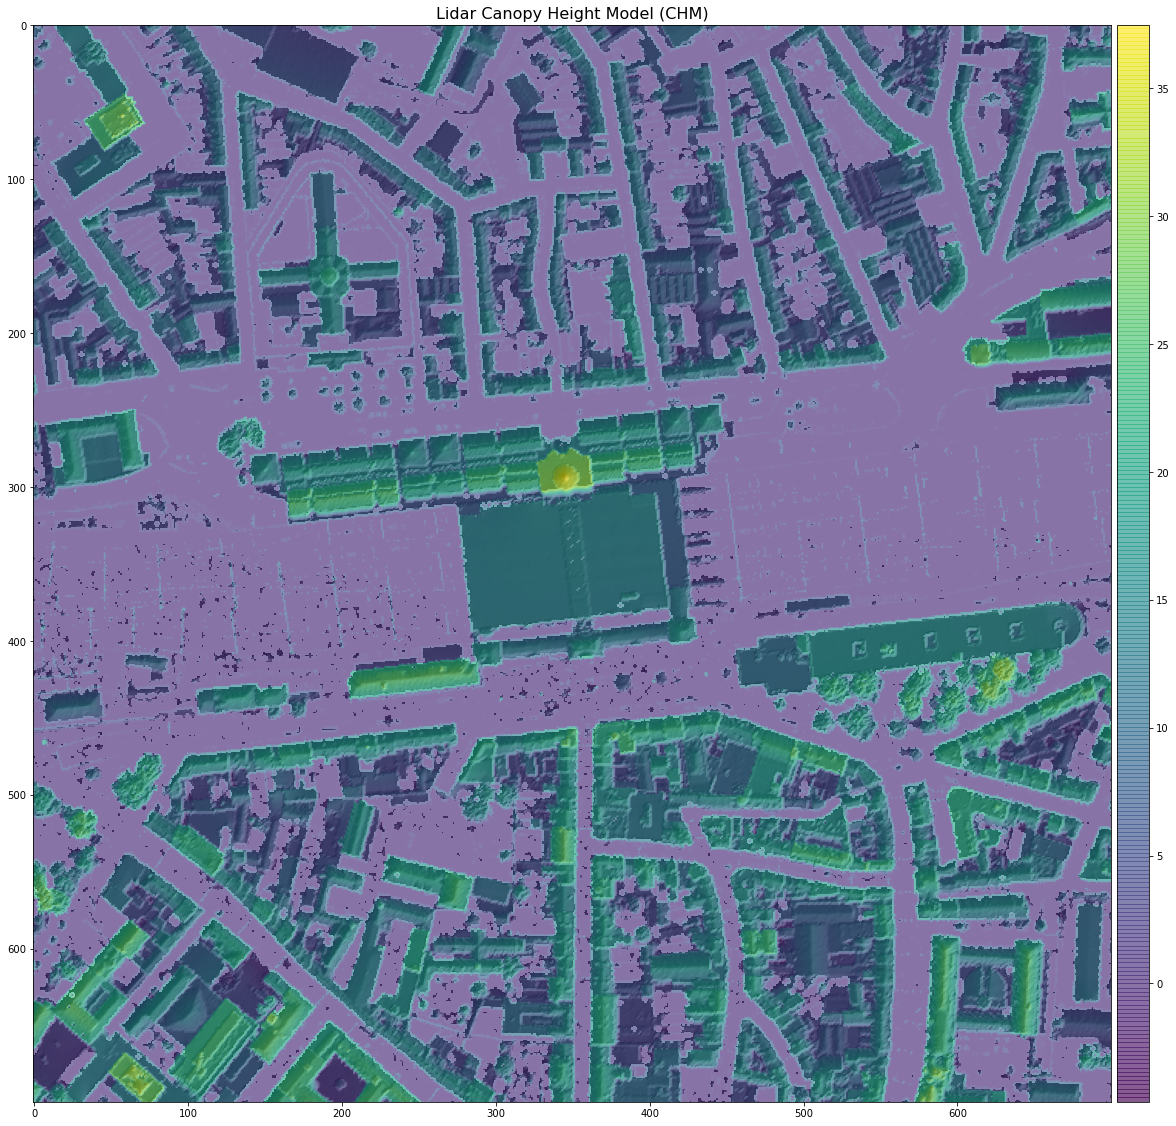

In [11]:
# create hillshade using hillshade function in earthpy
chm_hill = es.hillshade(clean_lidar_chm, 315, 45)

# plot the data
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(chm_hill, cmap='Greys')
chm_plot = ax.imshow(lidar_chm, 
                     cmap='viridis', 
                     alpha = .65)

ep.colorbar(chm_plot)
ax.set_title("Lidar Canopy Height Model (CHM)", fontsize=16);